**Data** **Reading**

In [25]:
import pandas as pd

In [26]:
file_path = "/content/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)
xls

In [30]:
# Read all tables in the file
customers = pd.read_excel(xls, "customers")
genders = pd.read_excel(xls, "genders")
cities = pd.read_excel(xls, "cities")
transactions = pd.read_excel(xls, "transactions")
branches = pd.read_excel(xls, "branches")
merchants = pd.read_excel(xls, "merchants")

In [31]:
#Show the first five rows
customers.head(), transactions.head()

(   customer_id  join_date  city_id  gender_id
 0            1 2022-01-08        7          1
 1            2 2023-05-02       20          2
 2            3 2023-05-14       15          1
 3            4 2022-11-25       11          2
 4            5 2023-04-26        8          1,
    transaction_id  customer_id transaction_date  ... coupon_name  burn_date branch_id
 0               1          733       2024-05-11  ...     uNY-568        NaT         7
 1               2          631       2023-05-15  ...     kBx-219 2023-06-04         5
 2               3          309       2022-11-13  ...     PLG-122        NaT         7
 3               4          695       2024-01-26  ...     Wzf-897        NaT         2
 4               5          288       2022-10-12  ...     qGb-428 2022-11-20         6
 
 [5 rows x 7 columns])

**Merge data into a single table**

In [36]:
# Integrating customer data with Gender and City
customers = customers.merge(genders, on="gender_id", how="left")
customers = customers.merge(cities, on="city_id", how="left")

In [37]:
# Merge transaction data with branches
transactions = transactions.merge(branches, on="branch_id", how="left")

In [38]:
# Integrate customer data with transactions
full_data = transactions.merge(customers, on="customer_id", how="left")

In [39]:
# Display final data
full_data.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id_x,merchant_id_y,join_date,city_id,gender_id,gender_name_x,city_name_x,gender_name_y,city_name_y
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,7,7,2023-05-16,15,2,Female,Aswan,Female,Aswan
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,9,9,2022-10-10,14,2,Female,Damietta,Female,Damietta
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,7,7,2022-05-30,2,1,Male,Alexandria,Male,Alexandria
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,18,18,2023-11-27,15,2,Female,Aswan,Female,Aswan
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,15,15,2021-09-04,14,1,Male,Damietta,Male,Damietta


**Customer Distribution Analysis by Gender and** **City**

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-43-0c97ce60e872>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_data, x="gender_id", palette="coolwarm")


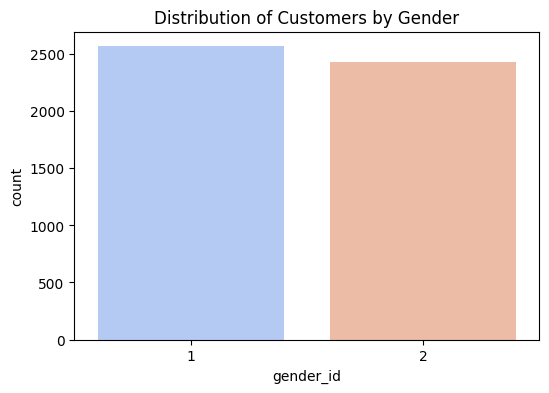

In [43]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=full_data, x="gender_id", palette="coolwarm")
plt.title("Distribution of Customers by Gender")
plt.show()

<ipython-input-45-17e6790e9516>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=full_data, y="city_id", palette="viridis")


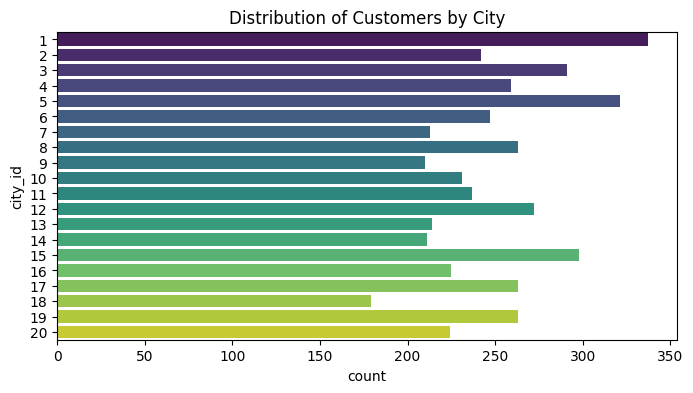

In [45]:
# ciry distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=full_data, y="city_id", palette="viridis")
plt.title("Distribution of Customers by City")
plt.show()

**Analysis of coupon usage over time**

In [46]:
#Convert a date column to datetime type
full_data["transaction_date"] = pd.to_datetime(full_data["transaction_date"])

In [47]:
# Calculate the number of transactions per month
monthly_usage = full_data.groupby(full_data["transaction_date"].dt.to_period("M")).size()

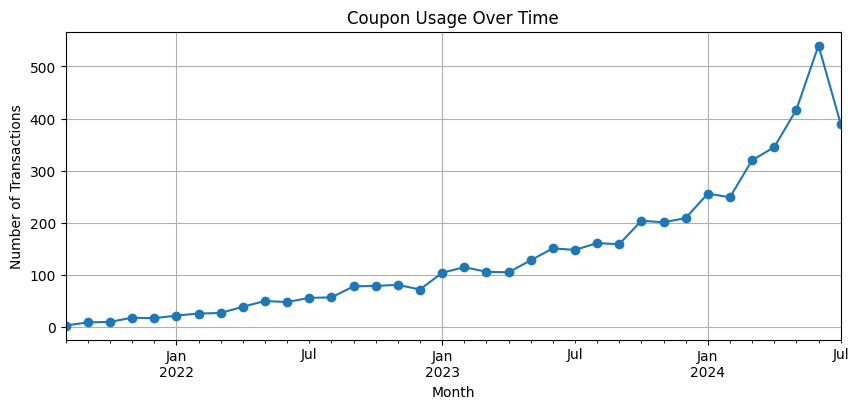

In [48]:
# Draw a timeline
plt.figure(figsize=(10, 4))
monthly_usage.plot(marker="o", linestyle="-")
plt.title("Coupon Usage Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.grid(True)
plt.show()

In [68]:
# Calculate the coupon burn rate for each city.
burn_rates = full_data[full_data["transaction_status"] == "burnt"].groupby("city_name").size()

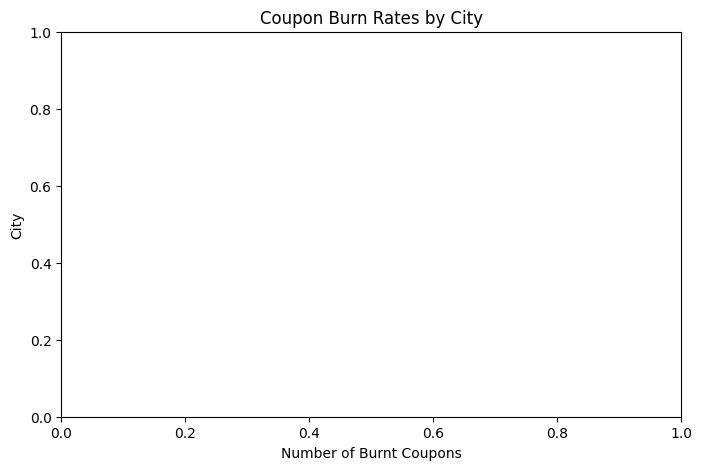

In [69]:
# Heat mapping
plt.figure(figsize=(8, 5))
sns.barplot(x=burn_rates.values, y=burn_rates.index, palette="coolwarm")
plt.title("Coupon Burn Rates by City")
plt.xlabel("Number of Burnt Coupons")
plt.ylabel("City")
plt.show()

**Preparing data for k-means use**

In [70]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the data for the fragmentation process
segmentation_data = full_data.copy()

In [71]:
# Calculate coupon usage rate and average retention time per customer
segmentation_data["coupon_usage_freq"] = segmentation_data.groupby("customer_id")["transaction_id"].transform("count")
segmentation_data["avg_burn_days"] = (segmentation_data["burn_date"] - segmentation_data["transaction_date"]).dt.days
segmentation_data["avg_burn_days"] = segmentation_data.groupby("customer_id")["avg_burn_days"].transform("mean")


In [74]:
# Categorical data coding
segmentation_data["gender_encoded"] = segmentation_data["gender_id"].astype("category").cat.codes
segmentation_data["city_encoded"] = segmentation_data["city_id"].astype("category").cat.codes

In [75]:
# Selecting features for segmentation analysis
features = ["gender_encoded", "city_encoded", "coupon_usage_freq", "avg_burn_days"]
X = segmentation_data[features]

In [76]:
# Data unification
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Select the optimal number of groups**

In [ ]:
from os import X_OK
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = {}
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = KMeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    silhouette_scores[k] = score

In [ ]:
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"the best number: {best_k}")

**K-MEANS**

In [ ]:
#  K-Means
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
segmentation_data["Cluster"] = final_kmeans.fit_predict(X_scaled)

In [ ]:
# Analysis of the characteristics of each group
cluster_summary = segmentation_data.groupby("Cluster")[features].mean()
cluster_summary

**Visually analyze slides**

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x=segmentation_data["Cluster"], palette="viridis")
plt.title("Distribution of Customers Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()

**Average coupon usage analysis for each grou**

In [ ]:
import numpy as np
usage_analysis = segmentation_data.groupby("Cluster")[["coupon_usage_freq", "avg_burn_days"]].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=usage_analysis.index, y=usage_analysis["coupon_usage_freq"], palette="viridis")
plt.title("Average Coupon Usage Frequency per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Coupon Usage")
plt.show()

**Analysis of the average retention time of coupons before burning them**

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=usage_analysis.index, y=usage_analysis["avg_burn_days"], palette="coolwarm")
plt.title("Average Days Before Burning Coupons per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Days to Burn Coupon")
plt.show()